In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0818.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0596.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_1428.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0540.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0532.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0840.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_1251.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0972.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0470.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0999.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_1117.txt
/kaggle/in

In [1]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections.abc import Iterable
import os
from PIL import Image
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
random.seed(42)
torch.manual_seed(42)
device=("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
batch_size=196
img_size=224

In [3]:
train_dir='/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train'
val_dir='/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val'

In [4]:
def file_lists(directory):
    images=[]
    labels=[]
    for cat in os.listdir(directory):
        for file in os.listdir(os.path.join(directory,cat,'images')):
            images.append(os.path.join(directory,cat,'images',file))
            labels.append(cat)
    return np.array(images),np.array(labels)

In [5]:
x_train,y_train=file_lists(train_dir)
x_valid,y_valid=file_lists(val_dir)
x_train[:5],y_train[:5]

(array(['/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/Tr-pi_0282.jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/Te-pi_0059.jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (538).jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (374).jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/Pituitary/images/p (455).jpg'],
       dtype='<U94'),
 array(['Pituitary', 'Pituitary', 'Pituitary', 'Pituitary', 'Pituitary'],
       dtype='<U10'))

In [6]:
from sklearn.model_selection import train_test_split
x_valid,x_test,y_valid,y_test=train_test_split(x_valid,y_valid,test_size=0.5,random_state=42,stratify=y_valid)
x_valid[:5],y_valid[:5]

(array(['/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/images/Tr-no_0048.jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/images/gg (558).jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/images/gg (495).jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/images/Tr-pi_1202.jpg',
        '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/images/gg (277).jpg'],
       dtype='<U92'),
 array(['No Tumor', 'Glioma', 'Glioma', 'Pituitary', 'Glioma'],
       dtype='<U10'))

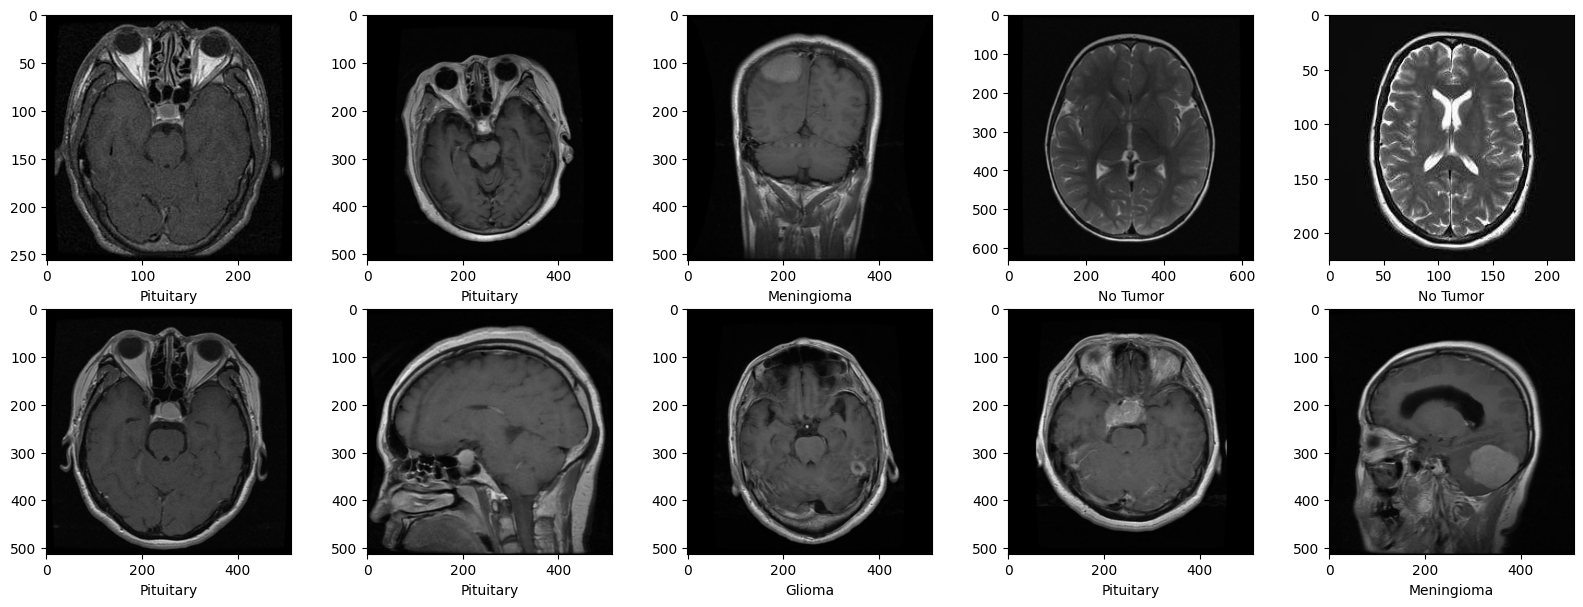

In [7]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    index=random.randint(0,len(x_train))
    img=cv2.imread(x_train[index])
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].set_xlabel(y_train[index])

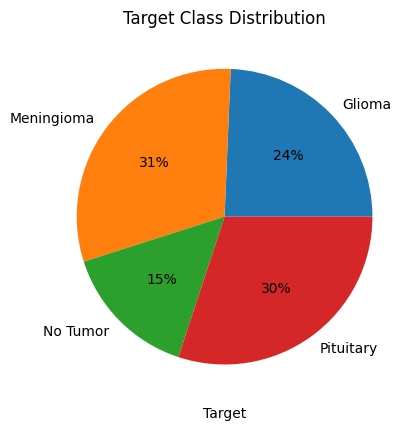

In [8]:
unique,count=np.unique(y_train,return_counts=True)
plt.pie(x=count,labels=unique,autopct='%.0f%%')
plt.xlabel('Target')
plt.title('Target Class Distribution')
plt.show()

In [9]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    clahe=cv2.createCLAHE(tileGridSize=(8,8),clipLimit=1)
    img[:,:,0]=clahe.apply(img[:,:,0])
    img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_LINEAR)
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    img=(img/255.0).astype(np.float32)
    img=np.moveaxis(img,-1,0)
    return img

In [10]:
x_train=np.array(list(map(image_preprocessing,x_train)))
x_valid=np.array(list(map(image_preprocessing,x_valid)))
x_test=np.array(list(map(image_preprocessing,x_test)))
x_train.shape,x_valid.shape,x_test.shape

((4737, 3, 224, 224), (256, 3, 224, 224), (256, 3, 224, 224))

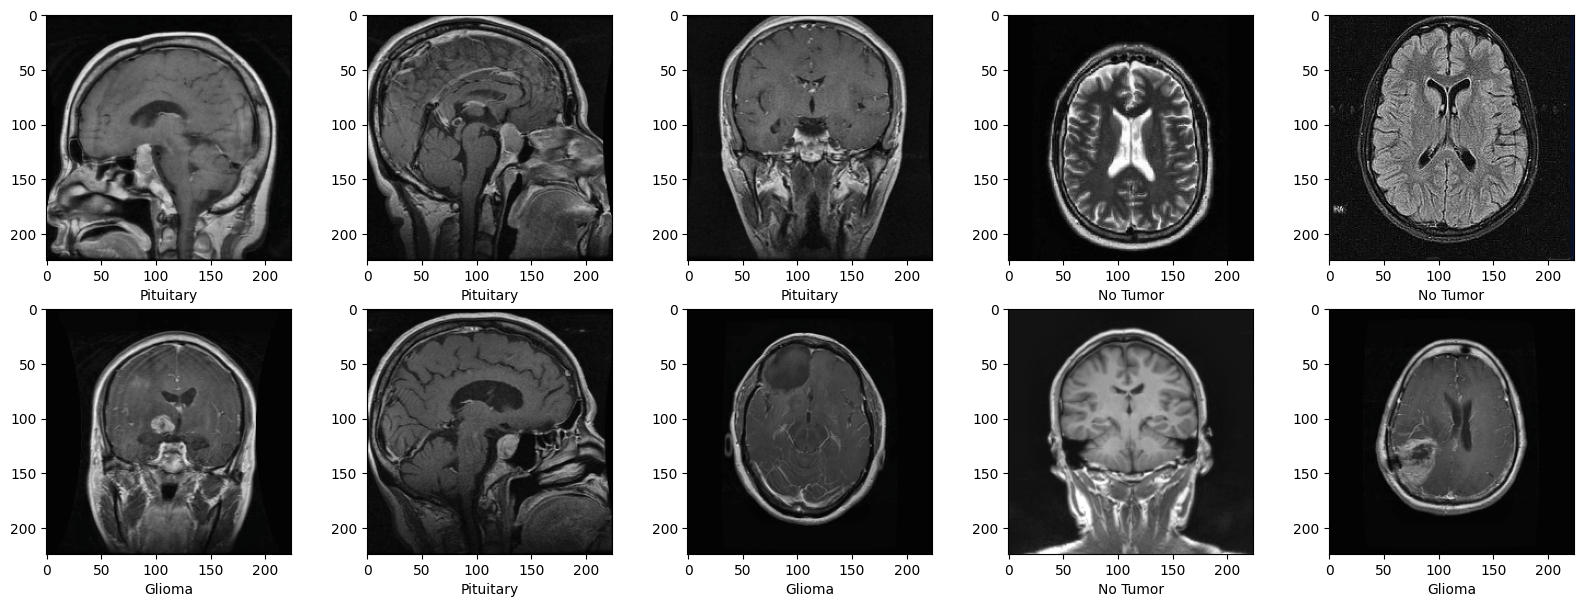

In [11]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    index=random.randint(0,len(x_train))
    img=np.moveaxis(x_train[index],0,-1)
    ax[i//5,i%5].imshow((img*255).astype('uint8'))
    ax[i//5,i%5].set_xlabel(y_train[index])

In [12]:
import numpy as np
class StandardScaler():
    def __init__(self) -> None:
        self.mean=None
        self.std=None
        
    def fit(self,tensor:np.ndarray) -> None:
        tensor=tensor.astype(np.float32)
        self.mean=np.mean(tensor,axis=(0,2,3),keepdims=True)
        self.std=np.std(tensor,axis=(0,2,3),keepdims=True)
        
    def transform(self,tensor:np.ndarray) -> np.ndarray:
        scaled=(tensor-self.mean)/(self.std)
        return scaled.astype(np.float32)
    
    def fit_transform(self,tensor:np.ndarray) -> np.ndarray:
        self.fit(tensor=tensor)
        scaled=self.transform(tensor=tensor)
        return scaled

In [13]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)
scaler.mean,scaler.std

(array([[[[0.22130735]],
 
         [[0.22175497]],
 
         [[0.22150236]]]], dtype=float32),
 array([[[[0.21355988]],
 
         [[0.213227  ]],
 
         [[0.21335492]]]], dtype=float32))

In [14]:
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)
y_valid=encoder.transform(y_valid)
y_train.shape,y_test.shape,y_valid.shape

((4737, 4), (256, 4), (256, 4))

In [15]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)
scaler.mean,scaler.std

(array([[[[2.1432434e-07]],
 
         [[3.6732277e-07]],
 
         [[9.6980079e-07]]]], dtype=float32),
 array([[[[0.99999994]],
 
         [[1.        ]],
 
         [[1.0000001 ]]]], dtype=float32))

In [16]:
from torch.utils.data import TensorDataset, DataLoader
def loading_data(x,y,batch_size,shuffle):
    x=torch.from_numpy(x.copy()).to(device)
    y=torch.from_numpy(y.copy()).to(device)
    dataset=TensorDataset(x,y)
    dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)
    return dataloader

In [17]:
train_loader=loading_data(x_train,y_train,batch_size,True)
val_loader=loading_data(x_valid,y_valid,batch_size,False)
test_loader=loading_data(x_test,y_test,batch_size,False)

In [23]:
import timm
class DeiT(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.base=timm.create_model(
                    'deit_tiny_patch16_224.fb_in1k',
                    pretrained=True,
                    num_classes=0,
                )
        self.out=torch.nn.Linear(192,num_classes)
    def forward(self,inputs):
        cls_token=self.base(inputs)
        return self.out(cls_token)

In [24]:
model = torch.nn.DataParallel(DeiT(num_classes=len(encoder.classes_))).to(device)
print(model)


DataParallel(
  (module): DeiT(
    (base): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_fea

In [ ]:
class Trainer():
    def __init__(self, 
                 model, 
                 loss_fn, 
                 T, 
                 init_lr, 
                 min_lr, 
                 optimizer, 
                 wd) -> None:
        assert optimizer in ['adamw','sgd'], 'Only support SGD or AdamW'
        self.model=model
        opt_choice={'adamw':torch.optim.AdamW(self.model.parameters(),
                                              lr=init_lr,
                                              weight_decay=wd),
                    'sgd':torch.optim.SGD(self.model.parameters(),
                                          lr=init_lr,weight_decay=wd,
                                          momentum=0.9)}
        self.opt=opt_choice[optimizer]
        self.sch=torch.optim.lr_scheduler.CosineAnnealingLR(self.opt,T,min_lr)
        self.loss_fn=loss_fn
        self.history={'losses':[], 
                      'val_losses':[]}
        
    def __trainstep(self,train_loader: DataLoader, verbose: int):
        self.model.train()
        train_loss=0
        batches=len(train_loader)
        if verbose == 1:
            train_loader=tqdm(train_loader)
        for x,y in train_loader:
            pred=self.model(x)
            loss=self.loss_fn(pred,y.float())
            if verbose==1:
                train_loader.set_postfix({'loss':loss.item()})
            train_loss+=loss.item()
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        train_loss/=batches
        if verbose == 1:
            train_loader.set_postfix({'loss':train_loss})
        self.history['losses'].append(train_loss)

    def __evalstep(self, val_loader: DataLoader,verbose: int):
        self.model.eval()
        val_loss=0
        batches=len(val_loader)
        if verbose == 1:
            val_loader=tqdm(val_loader)
        with torch.no_grad():
            for x,y in val_loader:
                pred=self.model(x)
                loss=self.loss_fn(pred,y.float())
                if verbose==1:
                    val_loader.set_postfix({'val_loss':loss.item()})
                val_loss+=loss.item()
        val_loss/=batches
        if verbose==1:
            val_loader.set_postfix({'val_loss':val_loss})
        self.history['val_losses'].append(val_loss)

    def fit(self, train_loader: DataLoader, 
            val_loader: DataLoader, 
            epochs: int, 
            verbose: int, 
            patience: int):
        assert verbose in [0,1], 'verbose must be either 0 or 1'
        best_loss = float('inf')
        best_model = None
        max_patience=patience
        for i in range(epochs):
            if verbose == 1:
                print(f'\nEpoch: {i+1}')
            self.__trainstep(train_loader, verbose)
            self.__evalstep(val_loader, verbose)
            if self.history['val_losses'][-1] - best_loss < 1e-6:
                best_loss=self.history['val_losses'][-1]
                best_model=self.model.state_dict()
                patience+=1
            else:
                patience-=1                                                         #patience is a early stopping
                if patience == 0:
                    break
            if self.sch:
                self.sch.step()
        self.model.load_state_dict(best_model)
        if verbose == 1:
            print(f'\nbest loss:', best_loss)
            
    def predict(self, test_loader: DataLoader):
        self.model.eval()
        test_preds=[]
        with torch.no_grad():
            for x in test_loader:
                pred=self.model(x[0])
                pred=torch.nn.Softmax(dim=1)(pred)
                test_preds.append(pred.cpu().numpy())
        test_preds=np.concatenate(test_preds,axis=0)
        return test_preds

In [26]:
trainer=Trainer(model=model,
                loss_fn=torch.nn.CrossEntropyLoss(),
                T=100,
                init_lr=1e-4,
                min_lr=1e-7,
                optimizer='adamw',
                wd=0.24)
trainer.model.module.base.eval()
for p in trainer.model.module.base.parameters():
    p.requires_grad=False

In [27]:
trainer.fit(train_loader=train_loader,
            val_loader=val_loader,
            epochs=100,
            verbose=1,
            patience=10)


Epoch: 1


100%|██████████| 2/2 [00:00<00:00, 13.23it/s, val_loss=1.31]



Epoch: 2


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=1.2] 



Epoch: 3


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=1.11]



Epoch: 4


100%|██████████| 2/2 [00:00<00:00, 13.23it/s, val_loss=1.03]



Epoch: 5


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.964]



Epoch: 6


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.911]



Epoch: 7


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.863]



Epoch: 8


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.818]



Epoch: 9


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.781]



Epoch: 10


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.748]



Epoch: 11


100%|██████████| 2/2 [00:00<00:00, 13.18it/s, val_loss=0.717]



Epoch: 12


100%|██████████| 2/2 [00:00<00:00, 13.35it/s, val_loss=0.691]



Epoch: 13


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=0.666]



Epoch: 14


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.643]



Epoch: 15


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.622]



Epoch: 16


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=0.603]



Epoch: 17


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.586]



Epoch: 18


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.567]



Epoch: 19


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.552]



Epoch: 20


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.538]



Epoch: 21


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.525]



Epoch: 22


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.512]



Epoch: 23


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.501]



Epoch: 24


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.49] 



Epoch: 25


100%|██████████| 2/2 [00:00<00:00, 13.34it/s, val_loss=0.48] 



Epoch: 26


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.469]



Epoch: 27


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.459]



Epoch: 28


100%|██████████| 2/2 [00:00<00:00, 13.15it/s, val_loss=0.451]



Epoch: 29


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.442]



Epoch: 30


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.436]



Epoch: 31


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=0.427]



Epoch: 32


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.42] 



Epoch: 33


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.414]



Epoch: 34


100%|██████████| 2/2 [00:00<00:00, 13.34it/s, val_loss=0.408]



Epoch: 35


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.402]



Epoch: 36


100%|██████████| 2/2 [00:00<00:00, 13.24it/s, val_loss=0.397]



Epoch: 37


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.391]



Epoch: 38


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.387]



Epoch: 39


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.381]



Epoch: 40


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.378]



Epoch: 41


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.373]



Epoch: 42


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.37]



Epoch: 43


100%|██████████| 2/2 [00:00<00:00, 13.34it/s, val_loss=0.365]



Epoch: 44


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.362]



Epoch: 45


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.358]



Epoch: 46


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.356]



Epoch: 47


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.353]



Epoch: 48


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.35] 



Epoch: 49


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.347]



Epoch: 50


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.344]



Epoch: 51


100%|██████████| 2/2 [00:00<00:00, 13.22it/s, val_loss=0.341]



Epoch: 52


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.338]



Epoch: 53


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.336]



Epoch: 54


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.335]



Epoch: 55


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.332]



Epoch: 56


100%|██████████| 2/2 [00:00<00:00, 13.14it/s, val_loss=0.33] 



Epoch: 57


100%|██████████| 2/2 [00:00<00:00, 13.15it/s, val_loss=0.328]



Epoch: 58


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.326]



Epoch: 59


100%|██████████| 2/2 [00:00<00:00, 13.24it/s, val_loss=0.324]



Epoch: 60


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.323]



Epoch: 61


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.321]



Epoch: 62


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.32] 



Epoch: 63


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.319]



Epoch: 64


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.318]



Epoch: 65


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.317]



Epoch: 66


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=0.315]



Epoch: 67


100%|██████████| 2/2 [00:00<00:00, 13.21it/s, val_loss=0.314]



Epoch: 68


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.314]



Epoch: 69


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.312]



Epoch: 70


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.312]



Epoch: 71


100%|██████████| 2/2 [00:00<00:00, 13.22it/s, val_loss=0.311]



Epoch: 72


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.31] 



Epoch: 73


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.309]



Epoch: 74


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.309]



Epoch: 75


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.308]



Epoch: 76


100%|██████████| 2/2 [00:00<00:00, 13.32it/s, val_loss=0.307]



Epoch: 77


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.307]



Epoch: 78


100%|██████████| 2/2 [00:00<00:00, 13.24it/s, val_loss=0.306]



Epoch: 79


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.306]



Epoch: 80


100%|██████████| 2/2 [00:00<00:00, 13.30it/s, val_loss=0.305]



Epoch: 81


100%|██████████| 2/2 [00:00<00:00, 13.23it/s, val_loss=0.305]



Epoch: 82


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.305]



Epoch: 83


100%|██████████| 2/2 [00:00<00:00, 13.33it/s, val_loss=0.305]



Epoch: 84


100%|██████████| 2/2 [00:00<00:00, 13.29it/s, val_loss=0.304]



Epoch: 85


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.304]



Epoch: 86


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.304]



Epoch: 87


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.304]



Epoch: 88


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.303]



Epoch: 89


100%|██████████| 2/2 [00:00<00:00, 13.22it/s, val_loss=0.303]



Epoch: 90


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=0.303]



Epoch: 91


100%|██████████| 2/2 [00:00<00:00, 13.26it/s, val_loss=0.303]



Epoch: 92


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.303]



Epoch: 93


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.303]



Epoch: 94


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.303]



Epoch: 95


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.303]



Epoch: 96


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.303]



Epoch: 97


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.303]



Epoch: 98


100%|██████████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.303]



Epoch: 99


100%|██████████| 2/2 [00:00<00:00, 13.31it/s, val_loss=0.303]



Epoch: 100


100%|██████████| 2/2 [00:00<00:00, 13.27it/s, val_loss=0.303]


best loss: 0.3646014332771301


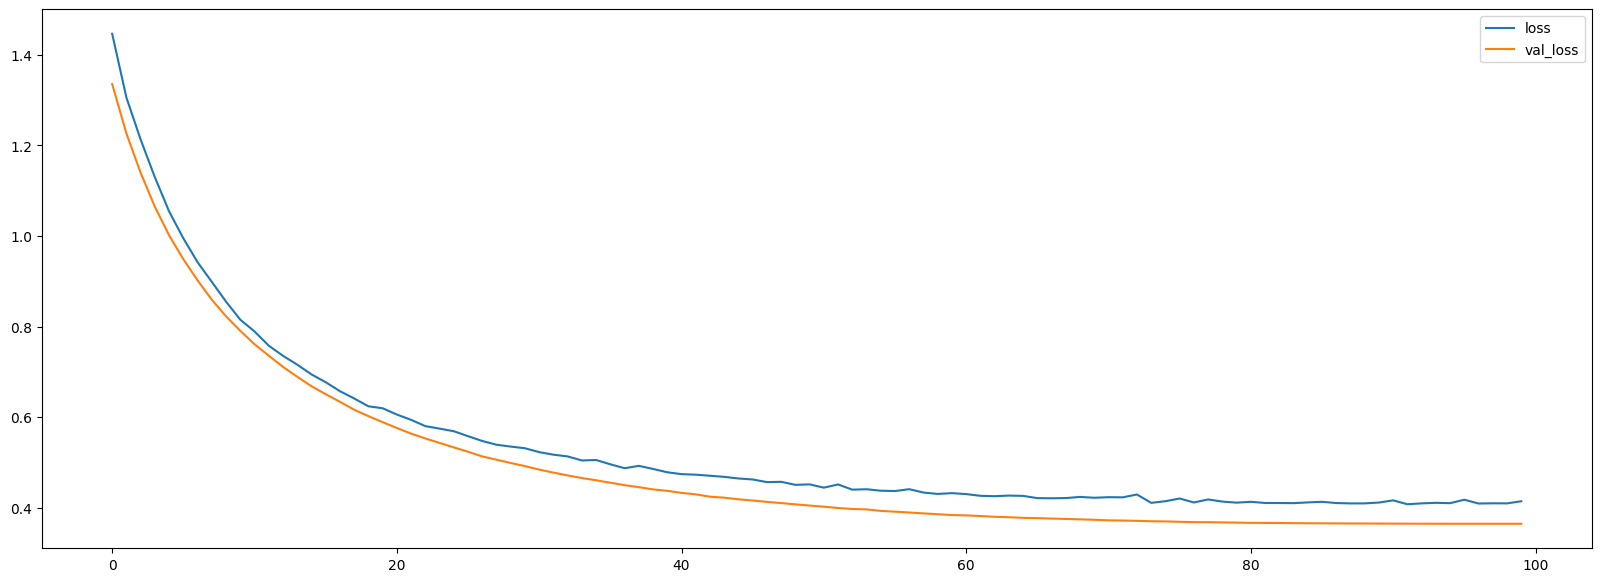

In [28]:
losses=trainer.history['losses']
val_losses=trainer.history['val_losses']
plt.figure(figsize=(20, 7))
plt.plot(range(len(losses)),losses)
plt.plot(range(len(val_losses)),val_losses)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [29]:
trainer.model.module.base.train()
for i in range(5,12):
    for p in trainer.model.module.base.blocks[i].parameters():
        p.requires_grad=True
for p in trainer.model.module.base.norm.parameters():
    p.requires_grad=True

trainer.fit(train_loader=train_loader,
        val_loader=val_loader,
        epochs=100,
        verbose=1,
        patience=10)


Epoch: 1


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.301]



Epoch: 2


100%|██████████| 2/2 [00:00<00:00, 11.85it/s, val_loss=0.299]



Epoch: 3


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.295]



Epoch: 4


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.29] 



Epoch: 5


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.282]



Epoch: 6


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.273]



Epoch: 7


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.26] 



Epoch: 8


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.246]



Epoch: 9


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.23]



Epoch: 10


100%|██████████| 2/2 [00:00<00:00, 11.75it/s, val_loss=0.215]



Epoch: 11


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.198]



Epoch: 12


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.185]



Epoch: 13


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.169]



Epoch: 14


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.155]



Epoch: 15


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.147]



Epoch: 16


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.13] 



Epoch: 17


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.118]



Epoch: 18


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.109]



Epoch: 19


100%|██████████| 2/2 [00:00<00:00, 11.88it/s, val_loss=0.0965]



Epoch: 20


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.0857]



Epoch: 21


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.0796]



Epoch: 22


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0699]



Epoch: 23


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.0635]



Epoch: 24


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0584]



Epoch: 25


100%|██████████| 2/2 [00:00<00:00, 11.93it/s, val_loss=0.0549]



Epoch: 26


100%|██████████| 2/2 [00:00<00:00, 11.71it/s, val_loss=0.0488]



Epoch: 27


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.052] 



Epoch: 28


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.0516]



Epoch: 29


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0476]



Epoch: 30


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.0453]



Epoch: 31


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0493]



Epoch: 32


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0492]



Epoch: 33


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0518]



Epoch: 34


100%|██████████| 2/2 [00:00<00:00, 11.85it/s, val_loss=0.05]  



Epoch: 35


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0513]



Epoch: 36


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0525]



Epoch: 37


100%|██████████| 2/2 [00:00<00:00, 11.77it/s, val_loss=0.051] 



Epoch: 38


100%|██████████| 2/2 [00:00<00:00, 11.76it/s, val_loss=0.0508]



Epoch: 39


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0529]



Epoch: 40


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0503]



Epoch: 41


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0501]



Epoch: 42


100%|██████████| 2/2 [00:00<00:00, 11.75it/s, val_loss=0.0509]



Epoch: 43


100%|██████████| 2/2 [00:00<00:00, 11.95it/s, val_loss=0.0491]



Epoch: 44


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.05]  



Epoch: 45


100%|██████████| 2/2 [00:00<00:00, 11.93it/s, val_loss=0.0498]



Epoch: 46


100%|██████████| 2/2 [00:00<00:00, 11.85it/s, val_loss=0.0487]



Epoch: 47


100%|██████████| 2/2 [00:00<00:00, 11.87it/s, val_loss=0.0431]



Epoch: 48


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0455]



Epoch: 49


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.0455]



Epoch: 50


100%|██████████| 2/2 [00:00<00:00, 11.84it/s, val_loss=0.0472]



Epoch: 51


100%|██████████| 2/2 [00:00<00:00, 11.89it/s, val_loss=0.0447]



Epoch: 52


100%|██████████| 2/2 [00:00<00:00, 11.75it/s, val_loss=0.0437]



Epoch: 53


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0428]



Epoch: 54


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.043] 



Epoch: 55


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.0434]



Epoch: 56


100%|██████████| 2/2 [00:00<00:00, 11.75it/s, val_loss=0.0421]



Epoch: 57


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0418]



Epoch: 58


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0411]



Epoch: 59


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0397]



Epoch: 60


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0396]



Epoch: 61


100%|██████████| 2/2 [00:00<00:00, 12.35it/s, val_loss=0.0393]



Epoch: 62


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.0385]



Epoch: 63


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.0372]



Epoch: 64


100%|██████████| 2/2 [00:00<00:00, 11.77it/s, val_loss=0.0374]



Epoch: 65


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.037] 



Epoch: 66


100%|██████████| 2/2 [00:00<00:00, 11.94it/s, val_loss=0.0354]



Epoch: 67


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0349]



Epoch: 68


100%|██████████| 2/2 [00:00<00:00, 11.83it/s, val_loss=0.0345]



Epoch: 69


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0343]



Epoch: 70


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.033] 



Epoch: 71


100%|██████████| 2/2 [00:00<00:00, 11.77it/s, val_loss=0.0322]



Epoch: 72


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0311]



Epoch: 73


100%|██████████| 2/2 [00:00<00:00, 11.76it/s, val_loss=0.0303]



Epoch: 74


100%|██████████| 2/2 [00:00<00:00, 11.82it/s, val_loss=0.0298]



Epoch: 75


100%|██████████| 2/2 [00:00<00:00, 11.80it/s, val_loss=0.0286]



Epoch: 76


100%|██████████| 2/2 [00:00<00:00, 11.89it/s, val_loss=0.0284]



Epoch: 77


100%|██████████| 2/2 [00:00<00:00, 11.74it/s, val_loss=0.0282]



Epoch: 78


100%|██████████| 2/2 [00:00<00:00, 11.85it/s, val_loss=0.027] 



Epoch: 79


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0276]



Epoch: 80


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0262]



Epoch: 81


100%|██████████| 2/2 [00:00<00:00, 11.77it/s, val_loss=0.0256]



Epoch: 82


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0247]



Epoch: 83


100%|██████████| 2/2 [00:00<00:00, 11.76it/s, val_loss=0.025] 



Epoch: 84


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0242]



Epoch: 85


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0241]



Epoch: 86


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.023] 



Epoch: 87


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0229]



Epoch: 88


100%|██████████| 2/2 [00:00<00:00, 11.75it/s, val_loss=0.0226]



Epoch: 89


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0216]



Epoch: 90


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0201]



Epoch: 91


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0196]



Epoch: 92


100%|██████████| 2/2 [00:00<00:00, 11.83it/s, val_loss=0.0198]



Epoch: 93


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0195]



Epoch: 94


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.019]



Epoch: 95


100%|██████████| 2/2 [00:00<00:00, 11.79it/s, val_loss=0.0172]



Epoch: 96


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0181]



Epoch: 97


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.0169]



Epoch: 98


100%|██████████| 2/2 [00:00<00:00, 11.91it/s, val_loss=0.0161]



Epoch: 99


100%|██████████| 2/2 [00:00<00:00, 11.78it/s, val_loss=0.0158]



Epoch: 100


100%|██████████| 2/2 [00:00<00:00, 11.81it/s, val_loss=0.015] 


best loss: 0.031449356116354465



------------------------Confusion Matrix - Validation Dataset------------------------


Classification Report

              precision    recall  f1-score   support

      Glioma       1.00      0.96      0.98        68
  Meningioma       0.96      0.99      0.97        70
    No Tumor       0.98      1.00      0.99        50
   Pituitary       1.00      1.00      1.00        68

   micro avg       0.98      0.98      0.98       256
   macro avg       0.98      0.99      0.98       256
weighted avg       0.98      0.98      0.98       256
 samples avg       0.98      0.98      0.98       256


Accuracy: 98.44%
--------------------------------------------------------------------------


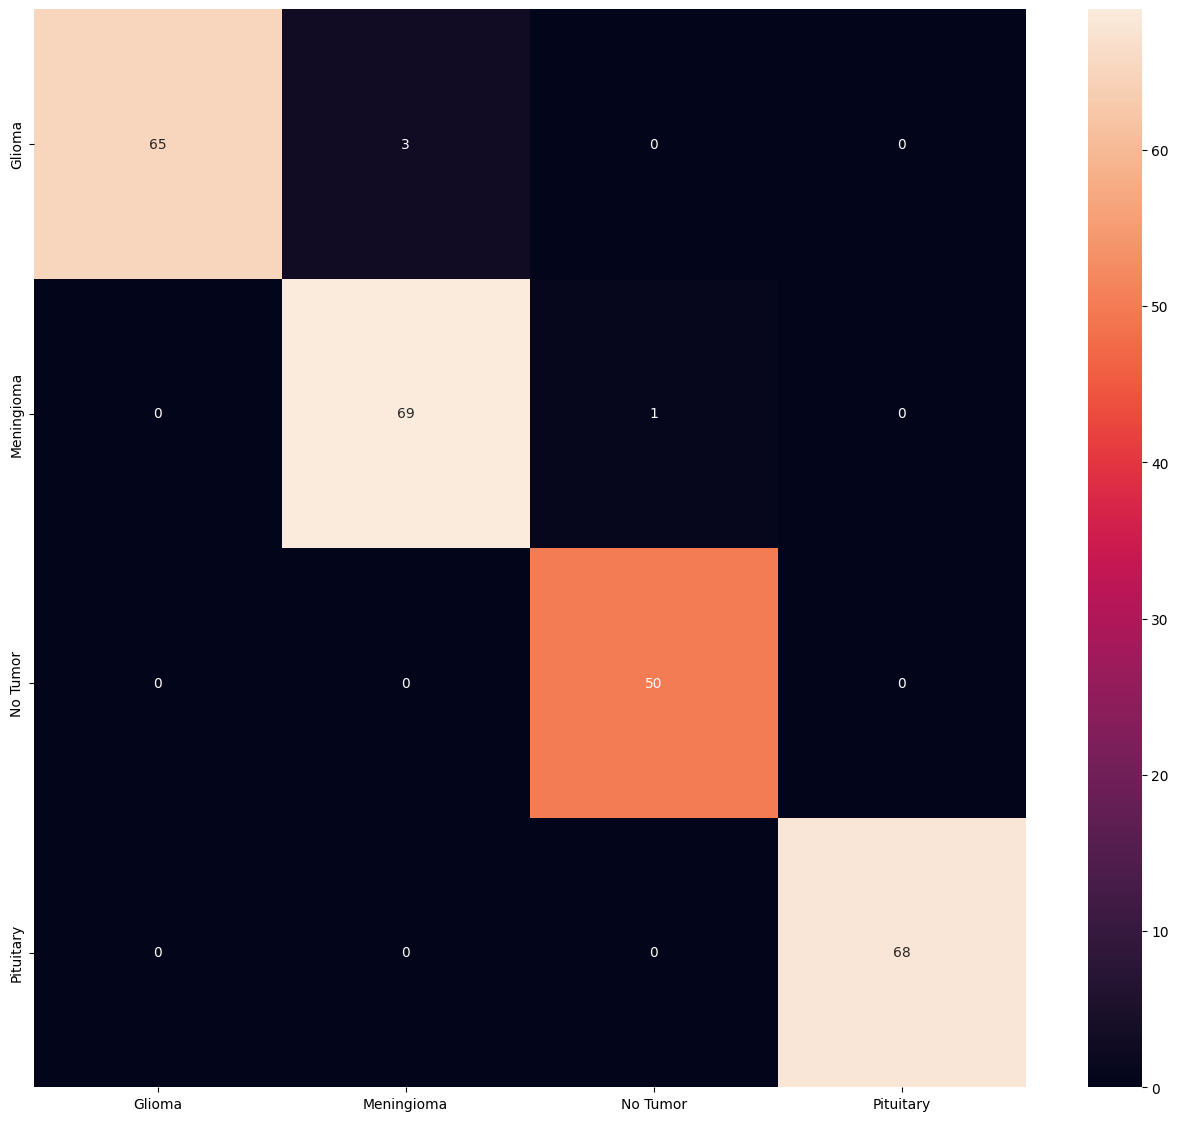


------------------------Confusion Matrix - Test Dataset------------------------


Classification Report

              precision    recall  f1-score   support

      Glioma       1.00      0.96      0.98        68
  Meningioma       0.95      1.00      0.97        70
    No Tumor       1.00      1.00      1.00        50
   Pituitary       1.00      0.99      0.99        68

   micro avg       0.98      0.98      0.98       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.98      0.98       256
 samples avg       0.98      0.98      0.98       256


Accuracy: 98.44%
--------------------------------------------------------------------------


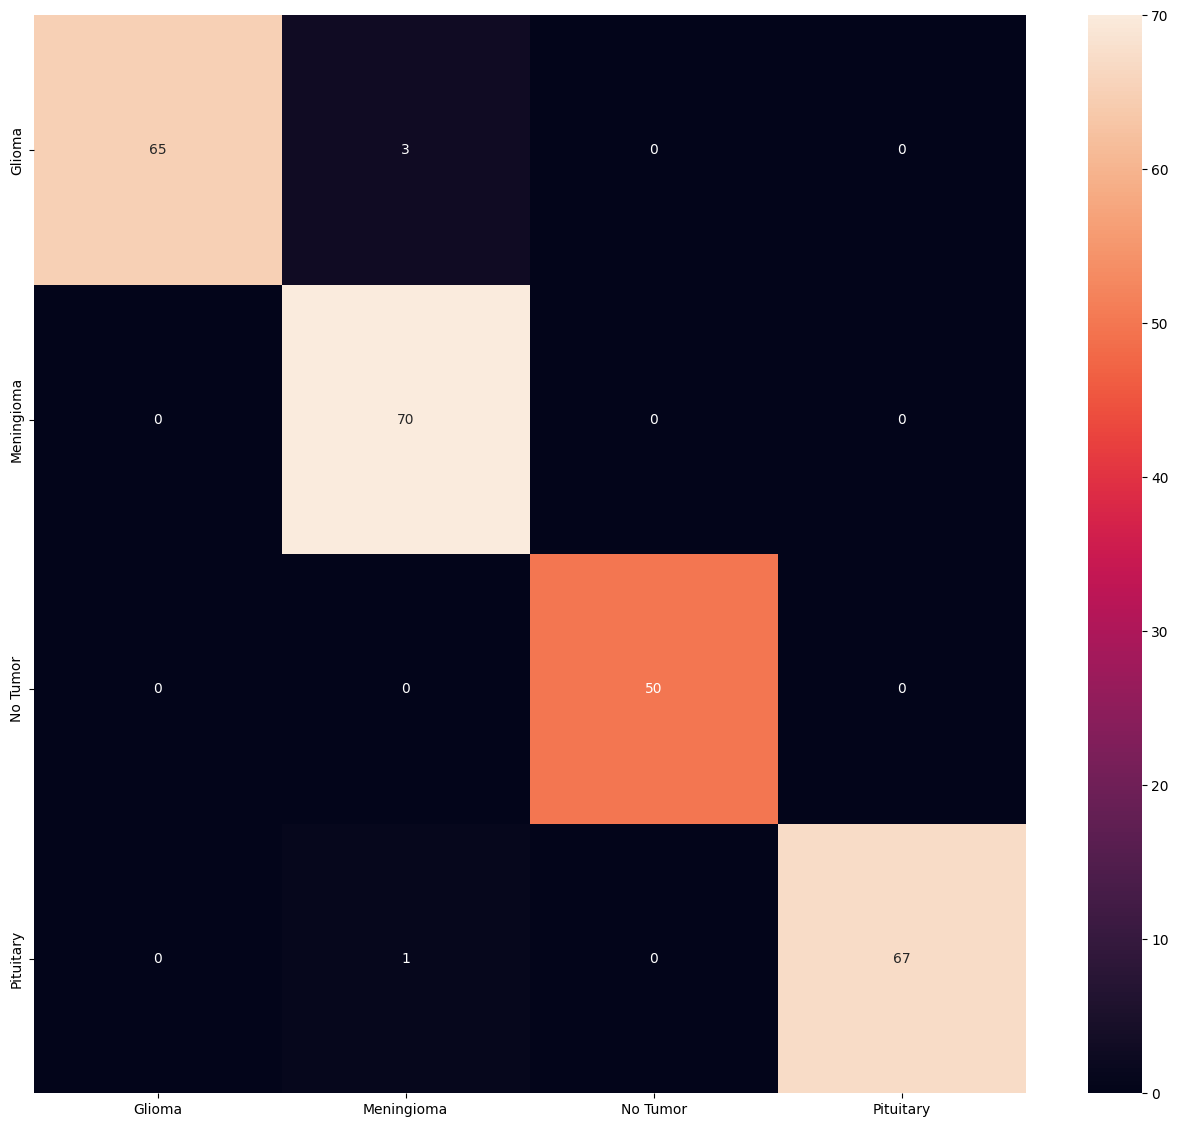

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation_parametrics(name, y_val, y_pred):
    print("\n------------------------{}------------------------\n".format(name))
    
    # Convert back to class labels
    y_val1 = encoder.inverse_transform(y_val)
    y_pred1 = encoder.inverse_transform(y_pred)
    
    # Compute confusion matrix
    cm_test = confusion_matrix(y_val1, y_pred1)
    
    # Compute accuracy
    accuracy = accuracy_score(y_val1, y_pred1)
    
    # Print classification report
    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred, target_names=encoder.classes_))
    
    # Print accuracy
    print("\nAccuracy: {:.2f}%".format(accuracy * 100))
    print("--------------------------------------------------------------------------")
    
    # Plot confusion matrix
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm_test, annot=True, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.show()

# Evaluate on validation set
evaluation_parametrics("Confusion Matrix - Validation Dataset", y_valid, np.round(trainer.predict(val_loader)))

# Evaluate on test set
evaluation_parametrics("Confusion Matrix - Test Dataset", y_test, np.round(trainer.predict(test_loader)))

In [38]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Ensure class labels match the training order
class_labels = ['Pituitary', 'Glioma', 'No tumor', 'Meningioma']

def detect_and_display(img_path, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    try:
        # Load image and apply transforms
        img = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Match model input size
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                                 [0.229, 0.224, 0.225])  # ImageNet std
        ])
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Ensure model is in eval mode
        model.eval()
        if isinstance(model, torch.nn.DataParallel):
            model = model.module  # unwrap DataParallel

        with torch.no_grad():
            outputs = model(img_tensor)
            predictions = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class_index = torch.argmax(predictions, dim=1).item()
            confidence_score = predictions[0][predicted_class_index].item()

        # Debug: print raw outputs
        print("Model raw output:", outputs)
        print("Softmax probabilities:", predictions)
        print("Predicted class:", class_labels[predicted_class_index])
        print("Confidence score:", confidence_score)

        # Result formatting
        if class_labels[predicted_class_index].lower() == 'no tumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Show the image
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


Model raw output: tensor([[ 3.8386,  7.9957, -4.3325, -6.7940]], device='cuda:0')
Softmax probabilities: tensor([[1.5411e-02, 9.8458e-01, 4.3571e-06, 3.7167e-07]], device='cuda:0')
Predicted class: Glioma
Confidence score: 0.9845840930938721


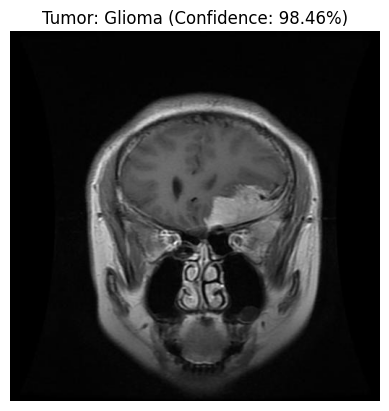

In [41]:
# Example usage
image_path = '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Meningioma/images/Tr-meTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)